# Capstone Project- The Battle of the Neighborhoods (Week 1)

### Introduction: Business Problem

This project will attempt to determine the types of venues that promote international tourism among top tourist destinations in the United States. Using international tourism data and venue location data by cities, the types of venues that are most popular among cities with high international tourism rates will be determined.

The types of venues that attract the most international tourism will be presented to state and federal legislators to provide an idea as to which type of attractions can boost international tourism rates. This information can help government revenues and local economies, provide employment, and benefit conservation of habitats and historic sites.

### Data

The type of data needed to solve this problem include the following:
* Number of international tourists per city in the US
* Types of venues located among the most popular tourism cities in the US
* Popularity of each venue within each city

Data sources and required information:
* International tourist data will be obtained from **Travel Trade** 
    * This data includes the **top 61** cities in the United States by estimation of overseas visitors in 2017 and 2018
* The center of each city will be acquired using **Google Maps API geocoding**
* The type and frequency of venues within each city will be found using the **Foursquare API**


This data will provide a list of venues to legislators that will increase international tourism for United States cities.


### 61 Most Popular Cities by International Tourism

The following code acquires the major international tourism destinations and average visitations per year within the United States by their Metropolitan Statistical Area (MSA).

In [69]:
#import the required libraries
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LinearRegression

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print("Libraries installed!")

Libraries installed!


In [2]:
url = "https://travel.trade.gov/outreachpages/download_data_table/US%20cities%20Visited%202018.xlsx"
travel_city = pd.read_excel(url)
travel_city = travel_city.drop(columns =['Unnamed: 0', 'Unnamed: 4']).iloc[4:].rename(columns={"Unnamed: 1":"City", "Unnamed: 2":"2018 Percentage", "Unnamed: 3":"2018 Total Visitors", "Unnamed: 5":"2017 Percentage", "Unnamed: 6":"2017 Total Visitors"}).reset_index(drop = True)
travel_city.dropna(axis = 0, how= "any", inplace = True)
travel_city["Avg Per Year"] = travel_city[["2018 Total Visitors", "2017 Total Visitors"]].mean(axis=1)
travel_city.head()

,City,2018 Percentage,2018 Total Visitors,2017 Percentage,2017 Total Visitors,Avg Per Year
0,"New York-White Plains-Wayne, NY-NJ",0.2647,10557,0.2592,10084,10320.5
1,"Miami-Miami Beach-Kendall, FL",0.1288,5137,0.1311,5101,5119.0
2,"Los Angeles-Long Beach-Glendale, CA",0.1272,5073,0.1225,4766,4919.5
3,"Orlando-Kissimmee-Sanford, FL",0.1091,4351,0.1196,4653,4502.0
4,"San Francisco-San Mateo-Redwood City, CA",0.0883,3522,0.0885,3443,3482.5


The Metropolitan Statistical Area (MSA) locations were condensend to one city (below) with the assumption that the first city/state listed accounts for the larger portion of tourism in the respective MSA. This was done to assist geolocator with finding coordinates for each location.

In [74]:
#Convert MSA to Individual cities
new_city = []
for row in travel_city["City"]:
    temp1 = row[:row.find(",")]
    if temp1.find("-") != -1:
        temp1 = temp1[:temp1.find("-")]
    if temp1.find("(") != -1:
        temp1 = temp1[:temp1.find("(")-1]
    temp2 = row[row.find(",")+2:row.find(",")+4]
    new_city.append(temp1 + ", " + temp2)

travel_city["City"] = new_city

print("Unique Locations:", travel_city["City"].nunique(), "Dataframe Shape:", travel_city.shape, "\n The 3 most popular cities are: \n", "1. ", travel_city["City"][0], "\n 2. ", travel_city["City"][1], "\n 3. ", travel_city["City"][2])

Unique Locations: 61 Dataframe Shape: (61, 8) 
 The 3 most popular cities are: 
 1.  New York, NY 
 2.  Miami, FL 
 3.  Los Angeles, CA


All tourist locations are unique! The following code finds the latitude and longitude for each city.



In [4]:
latitude = []
longitude = []

for row in travel_city["City"]:
    temp = None
    while(temp == None):
        geolocator = Nominatim(user_agent = "US_explorer")
        location = geolocator.geocode(row + ", USA")
        if location.latitude != None and location.longitude != None:
            latitude.append(location.latitude)
            longitude.append(location.longitude)
        temp = location.latitude
    
travel_city["Latitude"] = latitude
travel_city["Longitude"] = longitude

### Map United States Cities
The following code maps each of the most popular international tourist locations in the United States. 

In [6]:
#Make map
map_US = folium.Map(location=[48, -102], zoom_start=4)

#add markers to map for each neighborhood/borough
for lat, lng, city in zip(travel_city['Latitude'], travel_city['Longitude'], travel_city['City']):
    label = 'City: {}'.format(city)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        parse_html = False).add_to(map_US)

map_US

In [7]:
# The code was removed by Watson Studio for sharing.

### Find the Popular Venues Within Each City
The next steps determine the 60 most popular venues within each city.

In [8]:
limit = 60
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#Function to obtain nearby values given name, lat/lon, and radius
def getNearbyVenues(names, latitudes, longitudes, avg_year, radius=30000):
    venues_list=[]
    i = 1
    for name, lat, lng, avg_year in zip(names, latitudes, longitudes, avg_year): 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&sortByPopularity=1&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']

        # return only relevant information for each nearby venue
        for v in results:
            venues_list.append([(
            name, 
            avg_year,
            lat, 
            lng, 
            i,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'])])
            if i == 60:
                i = 1
            else:
                i = i + 1

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Avg Visitors Per Year',
                  'City Latitude', 
                  'City Longitude', 
                  'Venue Rank',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
city_venues = []
city_venues= getNearbyVenues(names=travel_city['City'],
                             latitudes=travel_city['Latitude'],
                             longitudes=travel_city['Longitude'],
                             avg_year=travel_city['Avg Per Year'])
city_venues

,City,Avg Visitors Per Year,City Latitude,City Longitude,Venue Rank,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"New York, NY",10320.5,40.712728,-74.006015,1,Central Park,40.784083,-73.964853,Park
1,"New York, NY",10320.5,40.712728,-74.006015,2,Bryant Park,40.753621,-73.983265,Park
2,"New York, NY",10320.5,40.712728,-74.006015,3,Prospect Park,40.661971,-73.971226,Park
3,"New York, NY",10320.5,40.712728,-74.006015,4,Brooklyn Bridge,40.705967,-73.996707,Bridge
4,"New York, NY",10320.5,40.712728,-74.006015,5,High Line,40.746825,-74.005507,Park
5,"New York, NY",10320.5,40.712728,-74.006015,6,The Metropolitan Museum of Art (Metropolitan M...,40.779729,-73.963416,Art Museum
6,"New York, NY",10320.5,40.712728,-74.006015,7,Madison Square Park,40.742262,-73.988006,Park
7,"New York, NY",10320.5,40.712728,-74.006015,8,Brooklyn Bridge Park,40.702282,-73.996456,Park
8,"New York, NY",10320.5,40.712728,-74.006015,9,Washington Square Park,40.730816,-73.997458,Park
9,"New York, NY",10320.5,40.712728,-74.006015,10,One World Trade Center,40.713069,-74.013133,Building


In [10]:
#Remove gyms and grocery stores from venues and retrieve top 30 venues
temp = city_venues[~city_venues["Venue Category"].str.contains('gym|grocery', flags=re.IGNORECASE)]
top_30_venues = temp.groupby("City").head(30).reset_index(drop = True)
top_30_venues

,City,Avg Visitors Per Year,City Latitude,City Longitude,Venue Rank,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"New York, NY",10320.5,40.712728,-74.006015,1,Central Park,40.784083,-73.964853,Park
1,"New York, NY",10320.5,40.712728,-74.006015,2,Bryant Park,40.753621,-73.983265,Park
2,"New York, NY",10320.5,40.712728,-74.006015,3,Prospect Park,40.661971,-73.971226,Park
3,"New York, NY",10320.5,40.712728,-74.006015,4,Brooklyn Bridge,40.705967,-73.996707,Bridge
4,"New York, NY",10320.5,40.712728,-74.006015,5,High Line,40.746825,-74.005507,Park
5,"New York, NY",10320.5,40.712728,-74.006015,6,The Metropolitan Museum of Art (Metropolitan M...,40.779729,-73.963416,Art Museum
6,"New York, NY",10320.5,40.712728,-74.006015,7,Madison Square Park,40.742262,-73.988006,Park
7,"New York, NY",10320.5,40.712728,-74.006015,8,Brooklyn Bridge Park,40.702282,-73.996456,Park
8,"New York, NY",10320.5,40.712728,-74.006015,9,Washington Square Park,40.730816,-73.997458,Park
9,"New York, NY",10320.5,40.712728,-74.006015,10,One World Trade Center,40.713069,-74.013133,Building


In [11]:
#Double check each city has 30 venues
top_30_venues.groupby('City').count()

,Avg Visitors Per Year,City Latitude,City Longitude,Venue Rank,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,,,
"Atlanta, GA",30,30,30,30,30,30,30,30
"Austin, TX",30,30,30,30,30,30,30,30
"Baltimore, MD",30,30,30,30,30,30,30,30
"Boston, MA",30,30,30,30,30,30,30,30
"Buffalo, NY",30,30,30,30,30,30,30,30
"Cambridge, MA",30,30,30,30,30,30,30,30
"Cape Coral, FL",30,30,30,30,30,30,30,30
"Charlotte, NC",30,30,30,30,30,30,30,30
"Chicago, IL",30,30,30,30,30,30,30,30


In [17]:
# one hot encoding
city_venues_30_onehot = pd.get_dummies(top_30_venues[['Venue Category']], prefix="", prefix_sep="")
city_venues_30_onehot['City'] = top_30_venues['City']
city_venues_30_onehot['Avg Visitors'] = top_30_venues['Avg Visitors Per Year']
city_venues_30_onehot['Latitude'] = top_30_venues['City Latitude']
city_venues_30_onehot['Longitude'] = top_30_venues['City Longitude']
city_venues_30_onehot['Venue Rank'] = top_30_venues['Venue Rank']

city_venues_30_onehot.head(6)

,Airport Lounge,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bagel Shop,...,Wine Shop,Winery,Wings Joint,Zoo,Zoo Exhibit,City,Avg Visitors,Latitude,Longitude,Venue Rank
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,5
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,6


In [19]:
#Weight the values by popularity and rank of venue
temp = city_venues_30_onehot.iloc[:,0:198].multiply(1-(city_venues_30_onehot["Venue Rank"]/60), axis="index")
temp['City'] = city_venues_30_onehot['City']
temp['Avg Visitors'] = city_venues_30_onehot['Avg Visitors']
temp['Latitude'] = city_venues_30_onehot['Latitude']
temp['Longitude'] = city_venues_30_onehot['Longitude']
temp.head(6)

,Airport Lounge,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bagel Shop,...,Waterfront,Wine Shop,Winery,Wings Joint,Zoo,Zoo Exhibit,City,Avg Visitors,Latitude,Longitude
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
5,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015


The weighted encoding was performed and done to account for the popularity of each venue, which was sorted by foursquare. Future projects can generate a better weight if "Checkins" per venue become available via foursquare.

In [27]:
city_grouped_mean = temp.groupby('City').mean().reset_index()
city_grouped_mean.head()

,City,Airport Lounge,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,...,Waterfall,Waterfront,Wine Shop,Winery,Wings Joint,Zoo,Zoo Exhibit,Avg Visitors,Latitude,Longitude
0,"Atlanta, GA",0.0,0.0,0.0,0.028889,0.0,0.00,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,722.5,33.749099,-84.390185
1,"Austin, TX",0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.038333,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,275.5,30.271129,-97.743699
2,"Baltimore, MD",0.0,0.0,0.0,0.026111,0.0,0.00,0.000000,0.0,0.000000,...,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,167.0,39.284749,-76.620475
3,"Boston, MA",0.0,0.0,0.0,0.000000,0.0,0.02,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1650.5,42.360253,-71.058291
4,"Buffalo, NY",0.0,0.0,0.0,0.000000,0.0,0.00,0.016667,0.0,0.000000,...,0.061667,0.0,0.000000,0.0,0.0,0.0,0.0,412.0,42.886717,-78.878392


In [31]:
city_grouped_sum = temp.groupby('City').sum().reset_index()
city_grouped_sum['Avg Visitors'] = city_grouped_mean['Avg Visitors']
city_grouped_sum['Latitude'] = city_grouped_mean['Latitude']
city_grouped_sum['Longitude'] = city_grouped_mean['Longitude']
city_grouped_sum.head()

,City,Airport Lounge,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,...,Waterfall,Waterfront,Wine Shop,Winery,Wings Joint,Zoo,Zoo Exhibit,Avg Visitors,Latitude,Longitude
0,"Atlanta, GA",0.0,0.0,0.0,0.866667,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,722.5,33.749099,-84.390185
1,"Austin, TX",0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.15,...,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,275.5,30.271129,-97.743699
2,"Baltimore, MD",0.0,0.0,0.0,0.783333,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,1.666667,0.0,0.0,0.0,0.0,167.0,39.284749,-76.620475
3,"Boston, MA",0.0,0.0,0.0,0.000000,0.0,0.6,0.0,0.0,0.00,...,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,1650.5,42.360253,-71.058291
4,"Buffalo, NY",0.0,0.0,0.0,0.000000,0.0,0.0,0.5,0.0,0.00,...,1.85,0.0,0.000000,0.0,0.0,0.0,0.0,412.0,42.886717,-78.878392


In [67]:
temp2 = city_grouped_sum.corr(method = "pearson")['Avg Visitors']
temp2[temp2 > 0.23]


Art Gallery                     0.265308
Art Museum                      0.440720
Bridge                          0.370333
Building                        0.304905
College Residence Hall          0.307758
Film Studio                     0.307758
Fountain                        0.516005
Memorial Site                   0.483483
Monument / Landmark             0.278116
Observatory                     0.307758
Park                            0.330190
Performing Arts Venue           0.318494
Public Art                      0.323124
Shopping Mall                   0.250944
Tennis Stadium                  0.483726
Theme Park Ride / Attraction    0.375002
Avg Visitors                    1.000000
Name: Avg Visitors, dtype: float64

The above venues tend to be positively correlated to the number of tourists that visit a city each year.

In [63]:
temp2[temp2 < -0.23]

American Restaurant    -0.237505
Fast Food Restaurant   -0.234437
Warehouse Store        -0.230096
Name: Avg Visitors, dtype: float64

The above venues tend to be negatively correlated to the number of tourists that visit a city each year.

In [28]:
#Function determines the most common venues for each row
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:199]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted= pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_grouped_mean['City']


for ind in np.arange(city_grouped_mean.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped_mean.iloc[ind, :], num_top_venues)

city_venues_sorted['Latitude'] = city_grouped_mean['Latitude']
city_venues_sorted['Longitude'] = city_grouped_mean['Longitude']
city_venues_sorted['Avg Visitors'] = city_grouped_mean['Avg Visitors']
city_venues_sorted.head()


,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,Latitude,Longitude,Avg Visitors
0,"Atlanta, GA",Park,Market,Farmers Market,Fast Food Restaurant,Baseball Stadium,Football Stadium,Shopping Plaza,Theme Park,Aquarium,Convenience Store,Sushi Restaurant,Botanical Garden,Mountain,Sports Club,Trail,33.749099,-84.390185,722.5
1,"Austin, TX",Park,Hotel,Gourmet Shop,Movie Theater,Trail,BBQ Joint,Coffee Shop,Warehouse Store,Racetrack,Capitol Building,Field,Pool,Pedestrian Plaza,Lake,Bar,30.271129,-97.743699,275.5
2,"Baltimore, MD",Fast Food Restaurant,Supermarket,Wine Shop,Park,Farmers Market,Shopping Mall,Baseball Stadium,Football Stadium,Furniture / Home Store,Brewery,Aquarium,Movie Theater,Lake,General Entertainment,Pizza Place,39.284749,-76.620475,167.0
3,"Boston, MA",Park,Supermarket,Plaza,Brewery,Shopping Mall,Baseball Stadium,Garden,Bakery,Historic Site,Market,Science Museum,Gourmet Shop,Movie Theater,Trail,Farmers Market,42.360253,-71.058291,1650.5
4,"Buffalo, NY",Supermarket,Park,Scenic Lookout,Waterfall,Café,Football Stadium,Tour Provider,Hockey Arena,State / Provincial Park,Event Space,Brewery,Greek Restaurant,Gourmet Shop,Arts & Crafts Store,Pizza Place,42.886717,-78.878392,412.0


## Cluster

k =  1 Cost =  1.8966997571341833
k =  2 Cost =  1.583346108080518
k =  3 Cost =  1.3596099279981737
k =  4 Cost =  1.2553916049185374
k =  5 Cost =  1.1349480735596709
k =  6 Cost =  1.0712789169973544
k =  7 Cost =  1.0269725795076279
k =  8 Cost =  0.9766215674996148
k =  9 Cost =  0.8937652380952381
k =  10 Cost =  0.8470176214277383


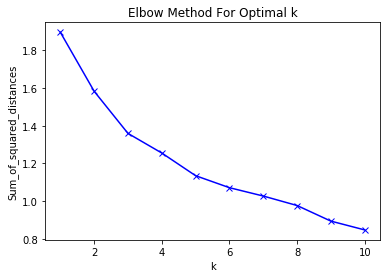

In [29]:
#Find best k value
city_grouped_clustering = city_grouped_mean.drop(['City', 'Latitude', 'Longitude', 'Avg Visitors'], axis = 1)
Sum_of_squared_distances = []
K = []
for k in range(1, 11):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0, n_init =12).fit(city_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)
    K.append(k)
    print("k = ", k, "Cost = ", kmeans.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
#Cluster with k = 5
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, init="k-means++", random_state=0, n_init =12).fit(city_grouped_clustering)

#Map clusters
#create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add clustering labels
city_grouped_mean.drop(columns= ['Cluster Labels'], inplace = True)
city_grouped_mean.insert(0, 'Cluster Labels', kmeans.labels_)

city_grouped_mean.head()